# Mini-Project #4 (Part B)

Student Name: **Subhadyuti Sahoo**
<br>
Course: **Adv Topics in Machine Learning**

### Importing Necessary Libraries, Modules and Classes

In [1]:
import os
import time
import datetime
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import statistics
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, PReLU, Dense, LSTM 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import losses
import warnings
from numpy.random import seed
tf.random.set_seed(1234)
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Importing the Dataset

In [2]:
# Forming the pandas dataframe
# entireDataSet = pd.read_csv('/content/drive/My Drive/AdvTopicsInML/NVDA.csv')   # for Google Colab
entireDataSet = pd.read_csv('NVDA.csv')   # for Jupyter Notebook

# Displaying the pandas dataFrame
display(entireDataSet)  

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508412,67867200
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666436,12762000
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537143,8580000
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532354,6109200
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.527566,5688000
...,...,...,...,...,...,...,...
5561,2021-03-01,555.000000,557.000000,542.130005,553.669983,553.669983,8802500
5562,2021-03-02,556.000000,556.820007,535.840027,536.250000,536.250000,6585500
5563,2021-03-03,537.049988,538.059998,511.950012,512.190002,512.190002,9408000
5564,2021-03-04,512.030029,519.000000,483.350006,494.809998,494.809998,14292400


<a id='Description'></a>
<div class=" alert alert-warning">
    <b>Description.</b>
 
Same as Mini-project #3, this project will use the historic adjusted closing price data of NVDA as the training/test data and build an artificial neural network (ANN) to predict the adjusted closing price in the future. We will only use the adjusted closing price. We will $60:20:20$ split the data for training, validation and test, reserving the most recent $20\%$ data for test, as though we had traveled back in time to September $30, 2016$. We will try to see if different activation function or LSTM can lead to better prediction with higher
accuracy.
    
</div>

### Extracting The Working Dataset

In [3]:
dSet = pd.DataFrame(entireDataSet['Adj Close'], columns=['Adj Close'])   # Working with only the Adjusted Closing Price

### Checking for Missing Values (if any)

In [4]:
# Checking if there are missing values in the workign dataset
result = (dSet.isna().values.any()) or (dSet.isnull().values.any())
if (result == True):
    n_missing_values = dSet.isna().sum().sum() + dSet.isnull().sum().sum()

# Displaying if there are any missing values in dataFrame
print('--- Checking for Missing Values ---')
print('Q. Are there any missing values in the dataset?')   
if (result == True):
    print('A. Yes')
    print('Q. How many?')
    print('A. ', n_missing_values)
else:
    print('A. No') 
print('-----------------------------------')
print('\n')

--- Checking for Missing Values ---
Q. Are there any missing values in the dataset?
A. No
-----------------------------------




### Splitting the Working Dataset

In [5]:
# Splitting the data after September 30, 2016
dates = entireDataSet['Date'].to_numpy()
trainval_indices = np.where(dates < '2016-10-01')
trainval_index_start = trainval_indices[0][0]
trainval_index_end = trainval_indices[0][-1]

# Converting the working dataset to a numpy array 
dSet = dSet.values
dSet = dSet.astype('float32')  # Converting to Tensor Form

# Splitting the working dataset into train, val and test datasets
n = (0.6 * len(dSet)) / trainval_index_end
trainDataSet = dSet[:int(n*trainval_index_end)]
valDataSet = dSet[int(n*trainval_index_end):trainval_index_end+1]
testDataSet = dSet[trainval_index_end+1:]
tempTestDates = entireDataSet['Date'][trainval_index_end+1:]

<a id='Student Task'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b>
 
As we discussed in class, one of the biggest issues with the ANN is its lack of memory when handling time-series data, and LSTM can potentially address this problem. Try to design an LSTM model for NVDA price prediction. Feel free to explore the possible designs of LSTM and the number of past days’ adjusted closing price to use as input. 

</div>

<a id='QuestionA'></a>
<div class=" alert alert-warning">
    <b>Question.</b>
 
Provide your model design description. 

</div>

<a id='AnswerQA'></a>
<div class=" alert alert-info">
    <b>Answer.</b>

$\textbf{Model Design Description}$: 

- $\texttt{LSTM}$ model was designed for the prediction of NVDA adjusted closing price with $\texttt{80}$ neurons in the hidden layer
    
- The number of prior days were varied between $\texttt{10}$ and $\texttt{30}$
    
- The model with the lowest MSE score for the validation dataset amongst all the different models has been ultimately chosen to be the best model
    
</div>

### User-Defined Function to Form Training, Validation and Test Datasets Depending Upon Prior Days

In [6]:
def get_refurbished_datasets(dataset, prior_days):
    """
    Returns the reconfigured datasets for 'n' prior days
  
    Args: 
      dataset (vector, shape = [n, 1]): the column of interest from the entire, bigger dataset
      prior_days (int): the number of prior days for which the column of interest needs to be reconfigured
    """
    
    # Forming empty lists to store data
    X_, y_ = [], []
    
    # Forming the reconfigured datasets for 'n' prior days
    for i in range(len(dataset)-prior_days):
        a = dataset[i:(i + prior_days), 0]
        X_.append(a)
        y_.append(dataset[i + prior_days, 0])
        
    # Returning the reconfigured datasets
    return np.array(X_), np.array(y_)

### Creating A User-Defined Function for Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Window Method

In [7]:
def get_features_wm(featureMatrix):
    """
    """
    
    # Converting the feature matrix 
    convertedFeatureMatrixWM = np.reshape(featureMatrix, (featureMatrix.shape[0], 1, featureMatrix.shape[1]))
    
    # Returning the converted feature matrix
    return convertedFeatureMatrixWM

### Creating A User-Defined Function for Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Time Steps

In [8]:
def get_features_ts(featureMatrix):
    """
    """
    
    # Converting the feature matrix 
    convertedFeatureMatrixTS = np.reshape(featureMatrix, (featureMatrix.shape[0], featureMatrix.shape[1], 1))
    
    # Returning the converted feature matrix
    return convertedFeatureMatrixTS

### Creating A User-Defined Function for Compiling Model for A LSTM Using Window Method

In [9]:
def create_model_wm(model, lstmUnits, prior_days):
    """
    """
    
    # Creating the model
    model.add(LSTM(units=lstmUnits, input_shape=(1, prior_days)))
    model.add(Dense(1))
      
    # Returning the model
    return model 

### Creating A User-Defined Function for Compiling Model for A LSTM Using Time Steps

In [10]:
def create_model_ts(model, lstmUnits, prior_days):
    """
    """
    
    # Creating the model
    model.add(LSTM(units=lstmUnits, input_shape=(prior_days, 1)))
    model.add(Dense(1))
      
    # Returning the model
    return model 

### Creating A User-Defined Function In Order To Compile Different ANN Models 

In [11]:
def compile_and_fit(model, trainFeatures, trainLabels, valFeatures,
                    valLabels, batchSize, n_epochs, verBose):
    """
    Returns a compiled model
  
    Args:
      model (keras sequential model): the filled model
      trainFeatures (array, shape = [m,n]): the training dataset features
      trainLabels (vector, shape = [m,1]): the training dataset labels
      valFeatures (array, shape = [p, n]): the validation dataset features
      valLabels (vector, shape = [p,1]): the validation dataset labels
      batchSize (int): the max no. of batches to be used for compiling the model
      n_epochs (int): the max no. iterations for simulating the model
    """

    # Compiling the model
    model.compile(# Objective (Loss) Function
                  loss = 'mean_squared_error',  # meanSquaredError

                  # Optimizer
                  optimizer = 'adam'
                 )
  
    # Training the model
    history = model.fit(x = trainFeatures,
                        y = trainLabels,
                        batch_size = batchSize, 
                        epochs = n_epochs,
                        validation_data = (valFeatures, valLabels),
                        verbose = verBose)
  
    # Returning the compiled model
    return history 

### Forming the Working Datasets for Training, Validation and Test for 10 Prior Days

In [12]:
# Mentioning the prior days
prior_days = 10

# Forming the final training dataset
X_train_10, y_train_10 = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val_10, y_val_10 = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test_10, y_test_10 = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' +str(prior_days)+ ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train_10.shape}')
print(f'Training Labels Dataset Shape: {y_train_10.shape}')
print(f'Validation Features Dataset Shape: {X_val_10.shape}')
print(f'Validation Labels Dataset Shape: {y_val_10.shape}')
print(f'Test Features Dataset Shape: {X_test_10.shape}')
print(f'Test Labels Dataset Shape: {y_test_10.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (10 Prior Days) ---
Training Features Dataset Shape: (3329, 10)
Training Labels Dataset Shape: (3329,)
Validation Features Dataset Shape: (1104, 10)
Validation Labels Dataset Shape: (1104,)
Test Features Dataset Shape: (1103, 10)
Test Labels Dataset Shape: (1103,)
----------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Window Method (10 Prior Days)

In [13]:
# Reshaping the feature matrices
X_train_10_wm = get_features_wm(featureMatrix=X_train_10)  # Training dataset
X_val_10_wm = get_features_wm(featureMatrix=X_val_10)  # Validation dataset
X_test_10_wm = get_features_wm(featureMatrix=X_test_10)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Window Method) ---')
print(f'Training Features Dataset Shape: {X_train_10_wm.shape}')
print(f'Training Labels Dataset Shape: {y_train_10.shape}')
print(f'Validation Features Dataset Shape: {X_val_10_wm.shape}')
print(f'Validation Labels Dataset Shape: {y_val_10.shape}')
print(f'Test Features Dataset Shape: {X_test_10_wm.shape}')
print(f'Test Labels Dataset Shape: {y_test_10.shape}')
print('---------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (10 Prior Days, Window Method) ---
Training Features Dataset Shape: (3329, 1, 10)
Training Labels Dataset Shape: (3329,)
Validation Features Dataset Shape: (1104, 1, 10)
Validation Labels Dataset Shape: (1104,)
Test Features Dataset Shape: (1103, 1, 10)
Test Labels Dataset Shape: (1103,)
---------------------------------------------------------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Time Steps (10 Prior Days)

In [14]:
# Reshaping the feature matrices
X_train_10_ts = get_features_ts(featureMatrix=X_train_10)  # Training dataset
X_val_10_ts = get_features_ts(featureMatrix=X_val_10)  # Validation dataset
X_test_10_ts = get_features_ts(featureMatrix=X_test_10)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Time Steps) ---')
print(f'Training Features Dataset Shape: {X_train_10_ts.shape}')
print(f'Training Labels Dataset Shape: {y_train_10.shape}')
print(f'Validation Features Dataset Shape: {X_val_10_ts.shape}')
print(f'Validation Labels Dataset Shape: {y_val_10.shape}')
print(f'Test Features Dataset Shape: {X_test_10_ts.shape}')
print(f'Test Labels Dataset Shape: {y_test_10.shape}')
print('------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (10 Prior Days, Time Steps) ---
Training Features Dataset Shape: (3329, 10, 1)
Training Labels Dataset Shape: (3329,)
Validation Features Dataset Shape: (1104, 10, 1)
Validation Labels Dataset Shape: (1104,)
Test Features Dataset Shape: (1103, 10, 1)
Test Labels Dataset Shape: (1103,)
------------------------------------------------------------------------------------------


### Compiling Model for The LSTM Using Window Method (10 Prior Days)

In [15]:
emptyModel10WM = Sequential()
filledModel10WM = create_model_wm(model=emptyModel10WM, lstmUnits=80, prior_days=10)

history10WM = compile_and_fit(model=filledModel10WM, trainFeatures=X_train_10_wm, trainLabels=y_train_10, 
                              valFeatures=X_val_10_wm, valLabels=y_val_10, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
105/105 [==============================] - 4s 6ms/step - loss: 109.1267 - val_loss: 257.1129
Epoch 2/120
105/105 [==============================] - 0s 4ms/step - loss: 27.1841 - val_loss: 200.8701
Epoch 3/120
105/105 [==============================] - 0s 3ms/step - loss: 16.8585 - val_loss: 168.1965
Epoch 4/120
105/105 [==============================] - 0s 3ms/step - loss: 12.5439 - val_loss: 147.9681
Epoch 5/120
105/105 [==============================] - 0s 4ms/step - loss: 8.9206 - val_loss: 131.3467
Epoch 6/120
105/105 [==============================] - 0s 4ms/step - loss: 6.8967 - val_loss: 118.6972
Epoch 7/120
105/105 [==============================] - 0s 4ms/step - loss: 5.5581 - val_loss: 108.3645
Epoch 8/120
105/105 [==============================] - 0s 4ms/step - loss: 4.0089 - val_loss: 100.3214
Epoch 9/120
105/105 [==============================] - 0s 3ms/step - loss: 3.6492 - val_loss: 94.0220
Epoch 10/120
105/105 [==============================] - 0s 3ms/step -

### Compiling Model for The LSTM Using Time Steps (10 Prior Days)

In [16]:
emptyModel10TS = Sequential()
filledModel10TS = create_model_ts(model=emptyModel10TS, lstmUnits=80, prior_days=10)

history10TS = compile_and_fit(model=filledModel10TS, trainFeatures=X_train_10_ts, trainLabels=y_train_10, 
                              valFeatures=X_val_10_ts, valLabels=y_val_10, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
105/105 [==============================] - 2s 7ms/step - loss: 95.7029 - val_loss: 192.4190
Epoch 2/120
105/105 [==============================] - 0s 4ms/step - loss: 9.6703 - val_loss: 142.2071
Epoch 3/120
105/105 [==============================] - 0s 4ms/step - loss: 5.0312 - val_loss: 116.6218
Epoch 4/120
105/105 [==============================] - 0s 4ms/step - loss: 3.2781 - val_loss: 98.9375
Epoch 5/120
105/105 [==============================] - 0s 4ms/step - loss: 2.0169 - val_loss: 87.0782
Epoch 6/120
105/105 [==============================] - 0s 4ms/step - loss: 1.3258 - val_loss: 78.3022
Epoch 7/120
105/105 [==============================] - 0s 4ms/step - loss: 0.9633 - val_loss: 71.8713
Epoch 8/120
105/105 [==============================] - 0s 4ms/step - loss: 0.6655 - val_loss: 67.2963
Epoch 9/120
105/105 [==============================] - 0s 4ms/step - loss: 0.5351 - val_loss: 63.5273
Epoch 10/120
105/105 [==============================] - 0s 4ms/step - loss: 0.

### Predicting Training and Validation MSE Scores for LSTMs Using Window Method and Time Steps (10 Prior Days)

In [17]:
# Calculating training and validation MSE scores for the LSTM using Window Method
y_train_10_wm_pred = filledModel10WM.predict(X_train_10_wm)
y_val_10_wm_pred = filledModel10WM.predict(X_val_10_wm)
trainMSEScore10WM = mean_squared_error(y_train_10, y_train_10_wm_pred[:,0])
valMSEScore10WM = mean_squared_error(y_val_10, y_val_10_wm_pred[:,0])

# Calculating training and validation MSE scores for the LSTM using Time Steps
y_train_10_ts_pred = filledModel10TS.predict(X_train_10_ts)
y_val_10_ts_pred = filledModel10TS.predict(X_val_10_ts)
trainMSEScore10TS = mean_squared_error(y_train_10, y_train_10_ts_pred[:,0])
valMSEScore10TS = mean_squared_error(y_val_10, y_val_10_ts_pred[:,0])

# Printing the MSE scores
print('--- MSE Scores (' + str(prior_days) + ' Prior Days) ---')
print('Train Score (Window Method): %.2f MSE' % (trainMSEScore10WM))
print('Validation Score (Window Method): %.2f MSE' % (valMSEScore10WM))
print('Train Score (Time Steps): %.2f MSE' % (trainMSEScore10TS))
print('Validation Score (Time Steps): %.2f MSE' % (valMSEScore10TS))
print('----------------------------------')

--- MSE Scores (10 Prior Days) ---
Train Score (Window Method): 0.26 MSE
Validation Score (Window Method): 18.97 MSE
Train Score (Time Steps): 0.24 MSE
Validation Score (Time Steps): 30.80 MSE
----------------------------------


### Forming the Working Datasets for Training, Validation and Test for 15 Prior Days

In [18]:
# Mentioning the prior days
prior_days = 15

# Forming the final training dataset
X_train_15, y_train_15 = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val_15, y_val_15 = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test_15, y_test_15 = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' +str(prior_days)+ ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train_15.shape}')
print(f'Training Labels Dataset Shape: {y_train_15.shape}')
print(f'Validation Features Dataset Shape: {X_val_15.shape}')
print(f'Validation Labels Dataset Shape: {y_val_15.shape}')
print(f'Test Features Dataset Shape: {X_test_15.shape}')
print(f'Test Labels Dataset Shape: {y_test_15.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (15 Prior Days) ---
Training Features Dataset Shape: (3324, 15)
Training Labels Dataset Shape: (3324,)
Validation Features Dataset Shape: (1099, 15)
Validation Labels Dataset Shape: (1099,)
Test Features Dataset Shape: (1098, 15)
Test Labels Dataset Shape: (1098,)
----------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Window Method (15 Prior Days)

In [19]:
# Reshaping the feature matrices
X_train_15_wm = get_features_wm(featureMatrix=X_train_15)  # Training dataset
X_val_15_wm = get_features_wm(featureMatrix=X_val_15)  # Validation dataset
X_test_15_wm = get_features_wm(featureMatrix=X_test_15)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Window Method) ---')
print(f'Training Features Dataset Shape: {X_train_15_wm.shape}')
print(f'Training Labels Dataset Shape: {y_train_15.shape}')
print(f'Validation Features Dataset Shape: {X_val_15_wm.shape}')
print(f'Validation Labels Dataset Shape: {y_val_15.shape}')
print(f'Test Features Dataset Shape: {X_test_15_wm.shape}')
print(f'Test Labels Dataset Shape: {y_test_15.shape}')
print('---------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (15 Prior Days, Window Method) ---
Training Features Dataset Shape: (3324, 1, 15)
Training Labels Dataset Shape: (3324,)
Validation Features Dataset Shape: (1099, 1, 15)
Validation Labels Dataset Shape: (1099,)
Test Features Dataset Shape: (1098, 1, 15)
Test Labels Dataset Shape: (1098,)
---------------------------------------------------------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Time Steps (15 Prior Days)

In [20]:
# Reshaping the feature matrices
X_train_15_ts = get_features_ts(featureMatrix=X_train_15)  # Training dataset
X_val_15_ts = get_features_ts(featureMatrix=X_val_15)  # Validation dataset
X_test_15_ts = get_features_ts(featureMatrix=X_test_15)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Time Steps) ---')
print(f'Training Features Dataset Shape: {X_train_15_ts.shape}')
print(f'Training Labels Dataset Shape: {y_train_15.shape}')
print(f'Validation Features Dataset Shape: {X_val_15_ts.shape}')
print(f'Validation Labels Dataset Shape: {y_val_15.shape}')
print(f'Test Features Dataset Shape: {X_test_15_ts.shape}')
print(f'Test Labels Dataset Shape: {y_test_15.shape}')
print('------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (15 Prior Days, Time Steps) ---
Training Features Dataset Shape: (3324, 15, 1)
Training Labels Dataset Shape: (3324,)
Validation Features Dataset Shape: (1099, 15, 1)
Validation Labels Dataset Shape: (1099,)
Test Features Dataset Shape: (1098, 15, 1)
Test Labels Dataset Shape: (1098,)
------------------------------------------------------------------------------------------


### Compiling Model for The LSTM Using Window Method (15 Prior Days)

In [21]:
emptyModel15WM = Sequential()
filledModel15WM = create_model_wm(model=emptyModel15WM, lstmUnits=80, prior_days=15)

history15WM = compile_and_fit(model=filledModel15WM, trainFeatures=X_train_15_wm, trainLabels=y_train_15, 
                              valFeatures=X_val_15_wm, valLabels=y_val_15, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 6ms/step - loss: 106.8108 - val_loss: 279.7719
Epoch 2/120
104/104 [==============================] - 0s 3ms/step - loss: 30.3124 - val_loss: 213.0731
Epoch 3/120
104/104 [==============================] - 0s 3ms/step - loss: 19.1142 - val_loss: 174.8688
Epoch 4/120
104/104 [==============================] - 0s 3ms/step - loss: 10.9950 - val_loss: 153.2382
Epoch 5/120
104/104 [==============================] - 0s 3ms/step - loss: 9.5246 - val_loss: 136.4647
Epoch 6/120
104/104 [==============================] - 0s 3ms/step - loss: 7.4884 - val_loss: 123.7127
Epoch 7/120
104/104 [==============================] - 0s 3ms/step - loss: 5.5596 - val_loss: 113.7686
Epoch 8/120
104/104 [==============================] - 0s 3ms/step - loss: 5.0902 - val_loss: 105.1366
Epoch 9/120
104/104 [==============================] - 0s 3ms/step - loss: 3.8564 - val_loss: 98.2012
Epoch 10/120
104/104 [==============================] - 0s 3ms/step -

### Compiling Model for The LSTM Using Time Steps (15 Prior Days)

In [22]:
emptyModel15TS = Sequential()
filledModel15TS = create_model_ts(model=emptyModel15TS, lstmUnits=80, prior_days=15)

history15TS = compile_and_fit(model=filledModel15TS, trainFeatures=X_train_15_ts, trainLabels=y_train_15, 
                              valFeatures=X_val_15_ts, valLabels=y_val_15, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 6ms/step - loss: 107.7071 - val_loss: 211.9875
Epoch 2/120
104/104 [==============================] - 0s 4ms/step - loss: 11.8715 - val_loss: 147.3957
Epoch 3/120
104/104 [==============================] - 0s 4ms/step - loss: 5.7762 - val_loss: 119.6957
Epoch 4/120
104/104 [==============================] - 0s 4ms/step - loss: 2.8304 - val_loss: 102.9829
Epoch 5/120
104/104 [==============================] - 0s 4ms/step - loss: 2.3074 - val_loss: 89.9481
Epoch 6/120
104/104 [==============================] - 0s 3ms/step - loss: 1.5622 - val_loss: 80.3419
Epoch 7/120
104/104 [==============================] - 0s 4ms/step - loss: 0.9902 - val_loss: 73.2488
Epoch 8/120
104/104 [==============================] - 0s 4ms/step - loss: 0.9285 - val_loss: 67.1093
Epoch 9/120
104/104 [==============================] - 0s 4ms/step - loss: 0.6025 - val_loss: 63.2798
Epoch 10/120
104/104 [==============================] - 0s 4ms/step - loss:

### Predicting Training and Validation MSE Scores for LSTMs Using Window Method and Time Steps (15 Prior Days)

In [23]:
# Calculating training and validation MSE scores for the LSTM using Window Method
y_train_15_wm_pred = filledModel15WM.predict(X_train_15_wm)
y_val_15_wm_pred = filledModel15WM.predict(X_val_15_wm)
trainMSEScore15WM = mean_squared_error(y_train_15, y_train_15_wm_pred[:,0])
valMSEScore15WM = mean_squared_error(y_val_15, y_val_15_wm_pred[:,0])

# Calculating training and validation MSE scores for the LSTM using Time Steps
y_train_15_ts_pred = filledModel15TS.predict(X_train_15_ts)
y_val_15_ts_pred = filledModel15TS.predict(X_val_15_ts)
trainMSEScore15TS = mean_squared_error(y_train_15, y_train_15_ts_pred[:,0])
valMSEScore15TS = mean_squared_error(y_val_15, y_val_15_ts_pred[:,0])

# Printing the MSE scores
print('--- MSE Scores (' + str(prior_days) + ' Prior Days) ---')
print('Train Score (Window Method): %.2f MSE' % (trainMSEScore15WM))
print('Validation Score (Window Method): %.2f MSE' % (valMSEScore15WM))
print('Train Score (Time Steps): %.2f MSE' % (trainMSEScore15TS))
print('Validation Score (Time Steps): %.2f MSE' % (valMSEScore15TS))
print('----------------------------------')

--- MSE Scores (15 Prior Days) ---
Train Score (Window Method): 0.27 MSE
Validation Score (Window Method): 19.93 MSE
Train Score (Time Steps): 0.23 MSE
Validation Score (Time Steps): 27.97 MSE
----------------------------------


### Forming the Working Datasets for Training, Validation and Test for 20 Prior Days

In [24]:
# Mentioning the prior days
prior_days = 20

# Forming the final training dataset
X_train_20, y_train_20 = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val_20, y_val_20 = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test_20, y_test_20 = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' +str(prior_days)+ ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train_20.shape}')
print(f'Training Labels Dataset Shape: {y_train_20.shape}')
print(f'Validation Features Dataset Shape: {X_val_20.shape}')
print(f'Validation Labels Dataset Shape: {y_val_20.shape}')
print(f'Test Features Dataset Shape: {X_test_20.shape}')
print(f'Test Labels Dataset Shape: {y_test_20.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (20 Prior Days) ---
Training Features Dataset Shape: (3319, 20)
Training Labels Dataset Shape: (3319,)
Validation Features Dataset Shape: (1094, 20)
Validation Labels Dataset Shape: (1094,)
Test Features Dataset Shape: (1093, 20)
Test Labels Dataset Shape: (1093,)
----------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Window Method (20 Prior Days)

In [25]:
# Reshaping the feature matrices
X_train_20_wm = get_features_wm(featureMatrix=X_train_20)  # Training dataset
X_val_20_wm = get_features_wm(featureMatrix=X_val_20)  # Validation dataset
X_test_20_wm = get_features_wm(featureMatrix=X_test_20)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Window Method) ---')
print(f'Training Features Dataset Shape: {X_train_20_wm.shape}')
print(f'Training Labels Dataset Shape: {y_train_20.shape}')
print(f'Validation Features Dataset Shape: {X_val_20_wm.shape}')
print(f'Validation Labels Dataset Shape: {y_val_20.shape}')
print(f'Test Features Dataset Shape: {X_test_20_wm.shape}')
print(f'Test Labels Dataset Shape: {y_test_20.shape}')
print('---------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (20 Prior Days, Window Method) ---
Training Features Dataset Shape: (3319, 1, 20)
Training Labels Dataset Shape: (3319,)
Validation Features Dataset Shape: (1094, 1, 20)
Validation Labels Dataset Shape: (1094,)
Test Features Dataset Shape: (1093, 1, 20)
Test Labels Dataset Shape: (1093,)
---------------------------------------------------------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Time Steps (20 Prior Days)

In [26]:
# Reshaping the feature matrices
X_train_20_ts = get_features_ts(featureMatrix=X_train_20)  # Training dataset
X_val_20_ts = get_features_ts(featureMatrix=X_val_20)  # Validation dataset
X_test_20_ts = get_features_ts(featureMatrix=X_test_20)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Time Steps) ---')
print(f'Training Features Dataset Shape: {X_train_20_ts.shape}')
print(f'Training Labels Dataset Shape: {y_train_20.shape}')
print(f'Validation Features Dataset Shape: {X_val_20_ts.shape}')
print(f'Validation Labels Dataset Shape: {y_val_20.shape}')
print(f'Test Features Dataset Shape: {X_test_20_ts.shape}')
print(f'Test Labels Dataset Shape: {y_test_20.shape}')
print('------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (20 Prior Days, Time Steps) ---
Training Features Dataset Shape: (3319, 20, 1)
Training Labels Dataset Shape: (3319,)
Validation Features Dataset Shape: (1094, 20, 1)
Validation Labels Dataset Shape: (1094,)
Test Features Dataset Shape: (1093, 20, 1)
Test Labels Dataset Shape: (1093,)
------------------------------------------------------------------------------------------


### Compiling Model for The LSTM Using Window Method (20 Prior Days)

In [27]:
emptyModel20WM = Sequential()
filledModel20WM = create_model_wm(model=emptyModel20WM, lstmUnits=80, prior_days=20)

history20WM = compile_and_fit(model=filledModel20WM, trainFeatures=X_train_20_wm, trainLabels=y_train_20, 
                              valFeatures=X_val_20_wm, valLabels=y_val_20, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 6ms/step - loss: 98.7278 - val_loss: 292.1434
Epoch 2/120
104/104 [==============================] - 0s 3ms/step - loss: 33.1830 - val_loss: 227.8363
Epoch 3/120
104/104 [==============================] - 0s 3ms/step - loss: 24.4922 - val_loss: 189.8798
Epoch 4/120
104/104 [==============================] - 0s 3ms/step - loss: 14.8565 - val_loss: 165.5349
Epoch 5/120
104/104 [==============================] - 0s 3ms/step - loss: 12.1020 - val_loss: 148.7367
Epoch 6/120
104/104 [==============================] - 0s 3ms/step - loss: 9.1551 - val_loss: 134.2705
Epoch 7/120
104/104 [==============================] - 0s 3ms/step - loss: 6.8075 - val_loss: 123.7372
Epoch 8/120
104/104 [==============================] - 0s 3ms/step - loss: 5.7203 - val_loss: 113.8383
Epoch 9/120
104/104 [==============================] - 0s 3ms/step - loss: 4.8580 - val_loss: 106.7936
Epoch 10/120
104/104 [==============================] - 0s 3ms/step 

### Compiling Model for The LSTM Using Time Steps (20 Prior Days)

In [28]:
emptyModel20TS = Sequential()
filledModel20TS = create_model_ts(model=emptyModel20TS, lstmUnits=80, prior_days=20)

history20TS = compile_and_fit(model=filledModel20TS, trainFeatures=X_train_20_ts, trainLabels=y_train_20, 
                              valFeatures=X_val_20_ts, valLabels=y_val_20, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 6ms/step - loss: 105.2840 - val_loss: 210.5322
Epoch 2/120
104/104 [==============================] - 0s 4ms/step - loss: 10.8166 - val_loss: 144.0518
Epoch 3/120
104/104 [==============================] - 0s 4ms/step - loss: 6.3159 - val_loss: 116.6619
Epoch 4/120
104/104 [==============================] - 0s 4ms/step - loss: 3.0153 - val_loss: 100.3772
Epoch 5/120
104/104 [==============================] - 0s 4ms/step - loss: 2.4252 - val_loss: 87.8931
Epoch 6/120
104/104 [==============================] - 0s 4ms/step - loss: 1.6256 - val_loss: 78.8070
Epoch 7/120
104/104 [==============================] - 0s 4ms/step - loss: 1.0011 - val_loss: 71.8982
Epoch 8/120
104/104 [==============================] - 0s 4ms/step - loss: 0.8547 - val_loss: 66.7592
Epoch 9/120
104/104 [==============================] - 0s 4ms/step - loss: 0.5903 - val_loss: 62.6293
Epoch 10/120
104/104 [==============================] - 0s 4ms/step - loss:

### Predicting Training and Validation MSE Scores for LSTMs Using Window Method and Time Steps (20 Prior Days)

In [29]:
# Calculating training and validation MSE scores for the LSTM using Window Method
y_train_20_wm_pred = filledModel20WM.predict(X_train_20_wm)
y_val_20_wm_pred = filledModel20WM.predict(X_val_20_wm)
trainMSEScore20WM = mean_squared_error(y_train_20, y_train_20_wm_pred[:,0])
valMSEScore20WM = mean_squared_error(y_val_20, y_val_20_wm_pred[:,0])

# Calculating training and validation MSE scores for the LSTM using Time Steps
y_train_20_ts_pred = filledModel20TS.predict(X_train_20_ts)
y_val_20_ts_pred = filledModel20TS.predict(X_val_20_ts)
trainMSEScore20TS = mean_squared_error(y_train_20, y_train_20_ts_pred[:,0])
valMSEScore20TS = mean_squared_error(y_val_20, y_val_20_ts_pred[:,0])

# Printing the MSE scores
print('--- MSE Scores (' + str(prior_days) + ' Prior Days) ---')
print('Train Score (Window Method): %.2f MSE' % (trainMSEScore20WM))
print('Validation Score (Window Method): %.2f MSE' % (valMSEScore20WM))
print('Train Score (Time Steps): %.2f MSE' % (trainMSEScore20TS))
print('Validation Score (Time Steps): %.2f MSE' % (valMSEScore20TS))
print('----------------------------------')

--- MSE Scores (20 Prior Days) ---
Train Score (Window Method): 0.72 MSE
Validation Score (Window Method): 22.37 MSE
Train Score (Time Steps): 0.24 MSE
Validation Score (Time Steps): 31.26 MSE
----------------------------------


### Forming the Working Datasets for Training, Validation and Test for 25 Prior Days

In [30]:
# Mentioning the prior days
prior_days = 25

# Forming the final training dataset
X_train_25, y_train_25 = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val_25, y_val_25 = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test_25, y_test_25 = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' +str(prior_days)+ ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train_25.shape}')
print(f'Training Labels Dataset Shape: {y_train_25.shape}')
print(f'Validation Features Dataset Shape: {X_val_25.shape}')
print(f'Validation Labels Dataset Shape: {y_val_25.shape}')
print(f'Test Features Dataset Shape: {X_test_25.shape}')
print(f'Test Labels Dataset Shape: {y_test_25.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (25 Prior Days) ---
Training Features Dataset Shape: (3314, 25)
Training Labels Dataset Shape: (3314,)
Validation Features Dataset Shape: (1089, 25)
Validation Labels Dataset Shape: (1089,)
Test Features Dataset Shape: (1088, 25)
Test Labels Dataset Shape: (1088,)
----------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Window Method (25 Prior Days)

In [31]:
# Reshaping the feature matrices
X_train_25_wm = get_features_wm(featureMatrix=X_train_25)  # Training dataset
X_val_25_wm = get_features_wm(featureMatrix=X_val_25)  # Validation dataset
X_test_25_wm = get_features_wm(featureMatrix=X_test_25)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Window Method) ---')
print(f'Training Features Dataset Shape: {X_train_25_wm.shape}')
print(f'Training Labels Dataset Shape: {y_train_25.shape}')
print(f'Validation Features Dataset Shape: {X_val_25_wm.shape}')
print(f'Validation Labels Dataset Shape: {y_val_25.shape}')
print(f'Test Features Dataset Shape: {X_test_25_wm.shape}')
print(f'Test Labels Dataset Shape: {y_test_25.shape}')
print('---------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (25 Prior Days, Window Method) ---
Training Features Dataset Shape: (3314, 1, 25)
Training Labels Dataset Shape: (3314,)
Validation Features Dataset Shape: (1089, 1, 25)
Validation Labels Dataset Shape: (1089,)
Test Features Dataset Shape: (1088, 1, 25)
Test Labels Dataset Shape: (1088,)
---------------------------------------------------------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Time Steps (25 Prior Days)

In [32]:
# Reshaping the feature matrices
X_train_25_ts = get_features_ts(featureMatrix=X_train_25)  # Training dataset
X_val_25_ts = get_features_ts(featureMatrix=X_val_25)  # Validation dataset
X_test_25_ts = get_features_ts(featureMatrix=X_test_25)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Time Steps) ---')
print(f'Training Features Dataset Shape: {X_train_25_ts.shape}')
print(f'Training Labels Dataset Shape: {y_train_25.shape}')
print(f'Validation Features Dataset Shape: {X_val_25_ts.shape}')
print(f'Validation Labels Dataset Shape: {y_val_25.shape}')
print(f'Test Features Dataset Shape: {X_test_25_ts.shape}')
print(f'Test Labels Dataset Shape: {y_test_25.shape}')
print('------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (25 Prior Days, Time Steps) ---
Training Features Dataset Shape: (3314, 25, 1)
Training Labels Dataset Shape: (3314,)
Validation Features Dataset Shape: (1089, 25, 1)
Validation Labels Dataset Shape: (1089,)
Test Features Dataset Shape: (1088, 25, 1)
Test Labels Dataset Shape: (1088,)
------------------------------------------------------------------------------------------


### Compiling Model for The LSTM Using Window Method (25 Prior Days)

In [33]:
emptyModel25WM = Sequential()
filledModel25WM = create_model_wm(model=emptyModel25WM, lstmUnits=80, prior_days=25)

history25WM = compile_and_fit(model=filledModel25WM, trainFeatures=X_train_25_wm, trainLabels=y_train_25, 
                              valFeatures=X_val_25_wm, valLabels=y_val_25, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 6ms/step - loss: 97.7513 - val_loss: 276.2377
Epoch 2/120
104/104 [==============================] - 0s 3ms/step - loss: 34.0434 - val_loss: 218.0072
Epoch 3/120
104/104 [==============================] - 0s 3ms/step - loss: 20.2927 - val_loss: 184.7613
Epoch 4/120
104/104 [==============================] - 0s 3ms/step - loss: 13.0353 - val_loss: 161.8704
Epoch 5/120
104/104 [==============================] - 0s 4ms/step - loss: 11.0287 - val_loss: 144.2974
Epoch 6/120
104/104 [==============================] - 0s 4ms/step - loss: 8.1935 - val_loss: 131.7013
Epoch 7/120
104/104 [==============================] - 0s 4ms/step - loss: 7.0513 - val_loss: 121.1395
Epoch 8/120
104/104 [==============================] - 0s 4ms/step - loss: 5.1196 - val_loss: 113.0195
Epoch 9/120
104/104 [==============================] - 0s 4ms/step - loss: 4.4193 - val_loss: 105.1556
Epoch 10/120
104/104 [==============================] - 0s 3ms/step 

### Compiling Model for The LSTM Using Time Steps (25 Prior Days)

In [34]:
emptyModel25TS = Sequential()
filledModel25TS = create_model_ts(model=emptyModel25TS, lstmUnits=80, prior_days=25)

history25TS = compile_and_fit(model=filledModel25TS, trainFeatures=X_train_25_ts, trainLabels=y_train_25, 
                              valFeatures=X_val_25_ts, valLabels=y_val_25, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 12ms/step - loss: 94.0056 - val_loss: 201.2903
Epoch 2/120
104/104 [==============================] - 0s 4ms/step - loss: 13.3193 - val_loss: 145.9908
Epoch 3/120
104/104 [==============================] - 0s 4ms/step - loss: 5.5923 - val_loss: 121.7334
Epoch 4/120
104/104 [==============================] - 0s 4ms/step - loss: 2.8992 - val_loss: 104.4740
Epoch 5/120
104/104 [==============================] - 0s 4ms/step - loss: 2.3485 - val_loss: 91.5552
Epoch 6/120
104/104 [==============================] - 0s 4ms/step - loss: 1.4088 - val_loss: 81.9003
Epoch 7/120
104/104 [==============================] - 0s 4ms/step - loss: 1.0661 - val_loss: 75.1095
Epoch 8/120
104/104 [==============================] - 0s 4ms/step - loss: 0.6951 - val_loss: 69.6617
Epoch 9/120
104/104 [==============================] - 0s 4ms/step - loss: 0.6311 - val_loss: 65.5333
Epoch 10/120
104/104 [==============================] - 0s 4ms/step - loss:

### Predicting Training and Validation MSE Scores for LSTMs Using Window Method and Time Steps (25 Prior Days)

In [35]:
# Calculating training and validation MSE scores for the LSTM using Window Method
y_train_25_wm_pred = filledModel25WM.predict(X_train_25_wm)
y_val_25_wm_pred = filledModel25WM.predict(X_val_25_wm)
trainMSEScore25WM = mean_squared_error(y_train_25, y_train_25_wm_pred[:,0])
valMSEScore25WM = mean_squared_error(y_val_25, y_val_25_wm_pred[:,0])

# Calculating training and validation MSE scores for the LSTM using Time Steps
y_train_25_ts_pred = filledModel25TS.predict(X_train_25_ts)
y_val_25_ts_pred = filledModel25TS.predict(X_val_25_ts)
trainMSEScore25TS = mean_squared_error(y_train_25, y_train_25_ts_pred[:,0])
valMSEScore25TS = mean_squared_error(y_val_25, y_val_25_ts_pred[:,0])

# Printing the MSE scores
print('--- MSE Scores (' + str(prior_days) + ' Prior Days) ---')
print('Train Score (Window Method): %.2f MSE' % (trainMSEScore25WM))
print('Validation Score (Window Method): %.2f MSE' % (valMSEScore25WM))
print('Train Score (Time Steps): %.2f MSE' % (trainMSEScore25TS))
print('Validation Score (Time Steps): %.2f MSE' % (valMSEScore25TS))
print('----------------------------------')

--- MSE Scores (25 Prior Days) ---
Train Score (Window Method): 0.33 MSE
Validation Score (Window Method): 22.66 MSE
Train Score (Time Steps): 0.22 MSE
Validation Score (Time Steps): 33.25 MSE
----------------------------------


### Forming the Working Datasets for Training, Validation and Test for 30 Prior Days

In [36]:
# Mentioning the prior days
prior_days = 30

# Forming the final training dataset
X_train_30, y_train_30 = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val_30, y_val_30 = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test_30, y_test_30 = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' +str(prior_days)+ ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train_30.shape}')
print(f'Training Labels Dataset Shape: {y_train_30.shape}')
print(f'Validation Features Dataset Shape: {X_val_30.shape}')
print(f'Validation Labels Dataset Shape: {y_val_30.shape}')
print(f'Test Features Dataset Shape: {X_test_30.shape}')
print(f'Test Labels Dataset Shape: {y_test_30.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (30 Prior Days) ---
Training Features Dataset Shape: (3309, 30)
Training Labels Dataset Shape: (3309,)
Validation Features Dataset Shape: (1084, 30)
Validation Labels Dataset Shape: (1084,)
Test Features Dataset Shape: (1083, 30)
Test Labels Dataset Shape: (1083,)
----------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Window Method (30 Prior Days)

In [37]:
# Reshaping the feature matrices
X_train_30_wm = get_features_wm(featureMatrix=X_train_30)  # Training dataset
X_val_30_wm = get_features_wm(featureMatrix=X_val_30)  # Validation dataset
X_test_30_wm = get_features_wm(featureMatrix=X_test_30)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Window Method) ---')
print(f'Training Features Dataset Shape: {X_train_30_wm.shape}')
print(f'Training Labels Dataset Shape: {y_train_30.shape}')
print(f'Validation Features Dataset Shape: {X_val_30_wm.shape}')
print(f'Validation Labels Dataset Shape: {y_val_30.shape}')
print(f'Test Features Dataset Shape: {X_test_30_wm.shape}')
print(f'Test Labels Dataset Shape: {y_test_30.shape}')
print('---------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (30 Prior Days, Window Method) ---
Training Features Dataset Shape: (3309, 1, 30)
Training Labels Dataset Shape: (3309,)
Validation Features Dataset Shape: (1084, 1, 30)
Validation Labels Dataset Shape: (1084,)
Test Features Dataset Shape: (1083, 1, 30)
Test Labels Dataset Shape: (1083,)
---------------------------------------------------------------------------------------------


### Reshaping Feature Matrices To Have The Form '[samples, time steps, features]' for A LSTM Using Time Steps (30 Prior Days)

In [38]:
# Reshaping the feature matrices
X_train_30_ts = get_features_ts(featureMatrix=X_train_30)  # Training dataset
X_val_30_ts = get_features_ts(featureMatrix=X_val_30)  # Validation dataset
X_test_30_ts = get_features_ts(featureMatrix=X_test_30)  # Test dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Time Steps) ---')
print(f'Training Features Dataset Shape: {X_train_30_ts.shape}')
print(f'Training Labels Dataset Shape: {y_train_30.shape}')
print(f'Validation Features Dataset Shape: {X_val_30_ts.shape}')
print(f'Validation Labels Dataset Shape: {y_val_30.shape}')
print(f'Test Features Dataset Shape: {X_test_30_ts.shape}')
print(f'Test Labels Dataset Shape: {y_test_30.shape}')
print('------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (30 Prior Days, Time Steps) ---
Training Features Dataset Shape: (3309, 30, 1)
Training Labels Dataset Shape: (3309,)
Validation Features Dataset Shape: (1084, 30, 1)
Validation Labels Dataset Shape: (1084,)
Test Features Dataset Shape: (1083, 30, 1)
Test Labels Dataset Shape: (1083,)
------------------------------------------------------------------------------------------


### Compiling Model for The LSTM Using Window Method (30 Prior Days)

In [39]:
emptyModel30WM = Sequential()
filledModel30WM = create_model_wm(model=emptyModel30WM, lstmUnits=80, prior_days=30)

history30WM = compile_and_fit(model=filledModel30WM, trainFeatures=X_train_30_wm, trainLabels=y_train_30, 
                              valFeatures=X_val_30_wm, valLabels=y_val_30, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 6ms/step - loss: 89.6782 - val_loss: 295.4275
Epoch 2/120
104/104 [==============================] - 0s 3ms/step - loss: 38.0330 - val_loss: 233.5281
Epoch 3/120
104/104 [==============================] - 0s 3ms/step - loss: 23.4356 - val_loss: 196.1981
Epoch 4/120
104/104 [==============================] - 0s 3ms/step - loss: 15.6886 - val_loss: 170.6824
Epoch 5/120
104/104 [==============================] - 0s 3ms/step - loss: 11.7282 - val_loss: 152.2704
Epoch 6/120
104/104 [==============================] - 0s 4ms/step - loss: 9.5972 - val_loss: 138.5152
Epoch 7/120
104/104 [==============================] - 0s 4ms/step - loss: 7.3278 - val_loss: 127.2289
Epoch 8/120
104/104 [==============================] - 0s 4ms/step - loss: 6.0848 - val_loss: 117.8547
Epoch 9/120
104/104 [==============================] - 0s 4ms/step - loss: 5.2651 - val_loss: 110.0357
Epoch 10/120
104/104 [==============================] - 0s 3ms/step 

### Compiling Model for The LSTM Using Time Steps (30 Prior Days)

In [40]:
emptyModel30TS = Sequential()
filledModel30TS = create_model_ts(model=emptyModel30TS, lstmUnits=80, prior_days=30)

history30TS = compile_and_fit(model=filledModel30TS, trainFeatures=X_train_30_ts, trainLabels=y_train_30, 
                              valFeatures=X_val_30_ts, valLabels=y_val_30, batchSize=32, n_epochs=120, verBose=1)

Epoch 1/120
104/104 [==============================] - 2s 7ms/step - loss: 107.9035 - val_loss: 214.9738
Epoch 2/120
104/104 [==============================] - 0s 5ms/step - loss: 13.3744 - val_loss: 146.5697
Epoch 3/120
104/104 [==============================] - 0s 5ms/step - loss: 5.2275 - val_loss: 121.7087
Epoch 4/120
104/104 [==============================] - 0s 5ms/step - loss: 2.9208 - val_loss: 108.8358
Epoch 5/120
104/104 [==============================] - 1s 5ms/step - loss: 1.8994 - val_loss: 95.1805
Epoch 6/120
104/104 [==============================] - 1s 5ms/step - loss: 1.3034 - val_loss: 85.2666
Epoch 7/120
104/104 [==============================] - 0s 5ms/step - loss: 0.9271 - val_loss: 78.5640
Epoch 8/120
104/104 [==============================] - 0s 5ms/step - loss: 0.6936 - val_loss: 76.0010
Epoch 9/120
104/104 [==============================] - 0s 5ms/step - loss: 0.5475 - val_loss: 69.2502
Epoch 10/120
104/104 [==============================] - 0s 4ms/step - loss:

### Predicting Training and Validation MSE Scores for LSTMs Using Window Method and Time Steps (30 Prior Days)

In [41]:
# Calculating training and validation MSE scores for the LSTM using Window Method
y_train_30_wm_pred = filledModel30WM.predict(X_train_30_wm)
y_val_30_wm_pred = filledModel30WM.predict(X_val_30_wm)
trainMSEScore30WM = mean_squared_error(y_train_30, y_train_30_wm_pred[:,0])
valMSEScore30WM = mean_squared_error(y_val_30, y_val_30_wm_pred[:,0])

# Calculating training and validation MSE scores for the LSTM using Time Steps
y_train_30_ts_pred = filledModel30TS.predict(X_train_30_ts)
y_val_30_ts_pred = filledModel30TS.predict(X_val_30_ts)
trainMSEScore30TS = mean_squared_error(y_train_30, y_train_30_ts_pred[:,0])
valMSEScore30TS = mean_squared_error(y_val_30, y_val_30_ts_pred[:,0])

# Printing the MSE scores
print('--- MSE Scores (' + str(prior_days) + ' Prior Days) ---')
print('Train Score (Window Method): %.2f MSE' % (trainMSEScore30WM))
print('Validation Score (Window Method): %.2f MSE' % (valMSEScore30WM))
print('Train Score (Time Steps): %.2f MSE' % (trainMSEScore30TS))
print('Validation Score (Time Steps): %.2f MSE' % (valMSEScore30TS))
print('----------------------------------')

--- MSE Scores (30 Prior Days) ---
Train Score (Window Method): 0.30 MSE
Validation Score (Window Method): 23.73 MSE
Train Score (Time Steps): 0.24 MSE
Validation Score (Time Steps): 40.15 MSE
----------------------------------


### Bar Plot of Traning and Validation MSE Scores for LSTMs Using Window Method and Time Steps (Different Prior Days)

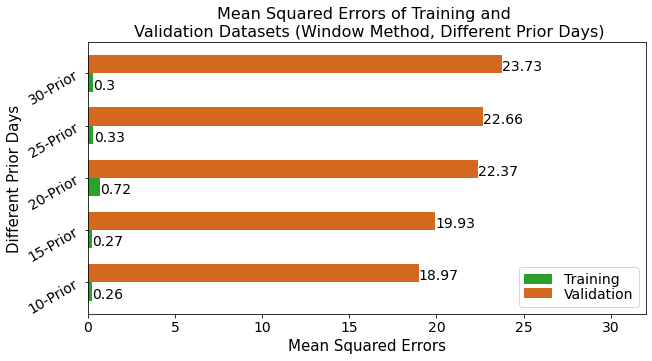

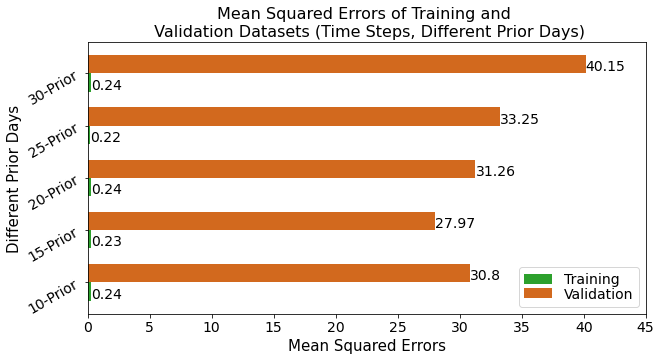

In [42]:
# Defining the names of rows for pandas DataFrame
indices = ['10-Prior', '15-Prior', '20-Prior', '25-Prior', '30-Prior']

# Creating a pandas DataFrame with MSE Scores of all Models
trainingMSEs = [round(trainMSEScore10WM,2), 
                round(trainMSEScore15WM,2),  
                round(trainMSEScore20WM,2),
                round(trainMSEScore25WM,2),
                round(trainMSEScore30WM,2)]
valMSEs = [round(valMSEScore10WM,2),
           round(valMSEScore15WM,2),
           round(valMSEScore20WM,2),
           round(valMSEScore25WM,2),
           round(valMSEScore30WM,2)]
dfMSE = pd.DataFrame({'Training': trainingMSEs, 
                      'Validation': valMSEs}, 
                     index = indices) 

# Plotting the bar-plots
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1)
dfMSE.plot(ax = ax, 
           kind = 'barh', 
           width = 0.7,
           color={"Training": "tab:green", 
                  "Validation": "chocolate"},
           rot = 30)
ax.set_ylabel('Different Prior Days', fontsize=15)
ax.set_xlabel('Mean Squared Errors', fontsize=15)
ax.set_xlim(0.0, 32.00)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Mean Squared Errors of Training and \n Validation Datasets (Window Method, Different Prior Days)", fontsize=16) 
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='lower right')

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.01, i.get_y()+.05, \
            str(round(i.get_width(), 2)), 
            fontsize=14)

plt.show()


# Creating a pandas DataFrame with MSE Scores of all Models
trainingMSEs = [round(trainMSEScore10TS,2), 
                round(trainMSEScore15TS,2),  
                round(trainMSEScore20TS,2),
                round(trainMSEScore25TS,2),
                round(trainMSEScore30TS,2)]
valMSEs = [round(valMSEScore10TS,2),
           round(valMSEScore15TS,2),
           round(valMSEScore20TS,2),
           round(valMSEScore25TS,2),
           round(valMSEScore30TS,2)]
dfMSE = pd.DataFrame({'Training': trainingMSEs, 
                      'Validation': valMSEs}, 
                     index = indices) 

# Plotting the bar-plots
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1)
dfMSE.plot(ax = ax, 
           kind = 'barh', 
           width = 0.7,
           color={"Training": "tab:green", 
                  "Validation": "chocolate"},
           rot = 30)
ax.set_ylabel('Different Prior Days', fontsize=15)
ax.set_xlabel('Mean Squared Errors', fontsize=15)
ax.set_xlim(0.0, 45.00)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Mean Squared Errors of Training and \n Validation Datasets (Time Steps, Different Prior Days)", fontsize=16) 
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='lower right')

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.01, i.get_y()+.05, \
            str(round(i.get_width(), 2)), 
            fontsize=14)

plt.show()

<a id='QuestionB'></a>
<div class=" alert alert-warning">
    <b>Question.</b>
 
Report the best model you can obtain that yields highest accuracy (lowest MSE). Plot your predicted adjusted closing prices from $10/1/16$ to now and the actual prices with respect to time, and report the MSE. Does LSTM model provide higher accuracy (lower MSE) on the test data?

</div>

<a id='AnswerQB'></a>
<div class=" alert alert-info">
    <b>Answer.</b>

$\textbf{Observation}$: In my case, the $\texttt{LSTM}$ model, created with $\textsf{Window Method}$ and containing $\texttt{1}$ hidden layer with $\texttt{80}$ hidden neurons for $\texttt{10}$ prior days, is the best model because the MSE score for the validation dataset ($\textsf{18.97}$) is the lowest for this model.
    
</div>

### Best Model: LSTM for 10 Prior Days

--- MSE Values for the Best LSTM Model (10 Prior Days) ---


Test Score: 56738.95 MSE


----------------------------------------------------------


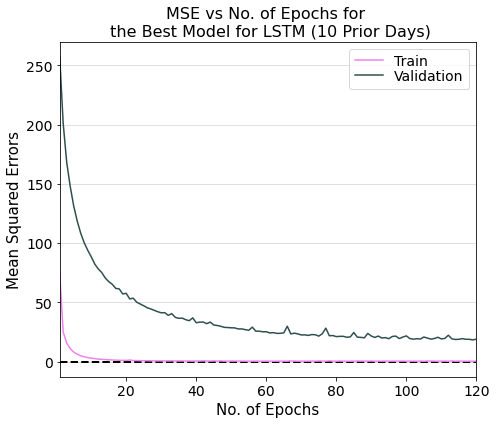

In [51]:
# Best ANN model
bestLSTMModel = filledModel10WM

# Estimating the prediction for test dataset with best ANN model
yTestPred = bestLSTMModel.predict(X_test_10_wm)

# Calculating the MSE of the test dataset
testMSE = mean_squared_error(y_test_10, yTestPred[:,0])

# Printing the MSE
print('--- MSE Values for the Best LSTM Model (10 Prior Days) ---')
print('\n')
print('Test Score: %.2f MSE' % (testMSE))
print('\n')
print('----------------------------------------------------------')

# Plotting training and validation MSE values v/s epochs for the Best ANN Model
titleString = "MSE vs No. of Epochs for \n the Best Model for LSTM (10 Prior Days)"
trainMSE = np.asarray(history10WM.history['loss']).reshape(-1,1) 
valMSE = np.asarray(history10WM.history['val_loss']).reshape(-1,1)
horzLine = np.linspace(1, 120)
horzLineData = np.array([0.00 for i in range(len(horzLine))])
fig, ax = plt.subplots(figsize=(7,6)) 
ax.plot(horzLine, horzLineData, 'k--', LineWidth=2)
ax.plot(range(1, 121), trainMSE, color='violet', label='Train')   
ax.plot(range(1, 121), valMSE, color='darkslategray', label='Validation')   
ax.set_title(titleString, fontsize=16)  
ax.set_ylabel('Mean Squared Errors', fontsize=15)   
ax.set_xlabel('No. of Epochs', fontsize=15)  
ax.set_xlim(left=1, right=120)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis='y', linestyle='-', alpha=0.5)
plt.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper right')   
plt.tight_layout()
plt.show()

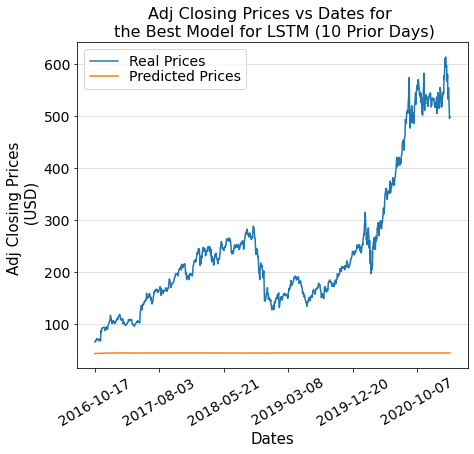

In [50]:
# Plotting the Real and Predicted Adjusted Closing Prices for the Best ANN Model
testDates = tempTestDates.iloc[10:]
dFrame = pd.DataFrame({'Date': testDates, 
                       'Real Prices': np.asarray(y_test_10).astype(np.float64).flatten(), 
                       'Predicted Prices': yTestPred[:,0].flatten()})
titleString = "Adj Closing Prices vs Dates for \n the Best Model for LSTM (10 Prior Days)"
fig, ax = plt.subplots(figsize=(7,6)) 
dFrame.plot(ax = ax, 
            x = "Date", 
            y = ["Real Prices", "Predicted Prices"],
            rot = 30)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(titleString, fontsize=16) 
ax.set_xlabel('Dates', fontsize=15)
ax.set_ylabel('Adj Closing Prices \n (USD)', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.5)
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper left')
plt.show() 